
=== SIMULATION RESULTS ===

1. First 10 rows of the dataset:
   student_id  class_id         y  x
0           1        39 -0.838322  0
1           2       190  2.459109  1
2           3       198 -1.578246  1
3           4       218 -1.605218  1
4           5        93 -2.016562  0
5           6        86 -0.022996  0
6           7        36  0.248913  0
7           8       161 -0.164968  1
8           9       104 -1.346354  1
9          10       223 -1.030369  1

2. Treatment distribution:
Regular class (x=0): 2500
Reduced class (x=1): 2500

3. Class size information:
Number of regular classes: 100
Number of reduced classes: 139
Average regular class size: 25.00
Average reduced class size: 17.99

4. Treatment effect check:
Average test score in reduced classes: 0.231
Average test score in regular classes: -0.019
Observed difference (should be close to delta=0.25): 0.249

Part (c) - Regression Analysis:
                            OLS Regression Results                            
Dep

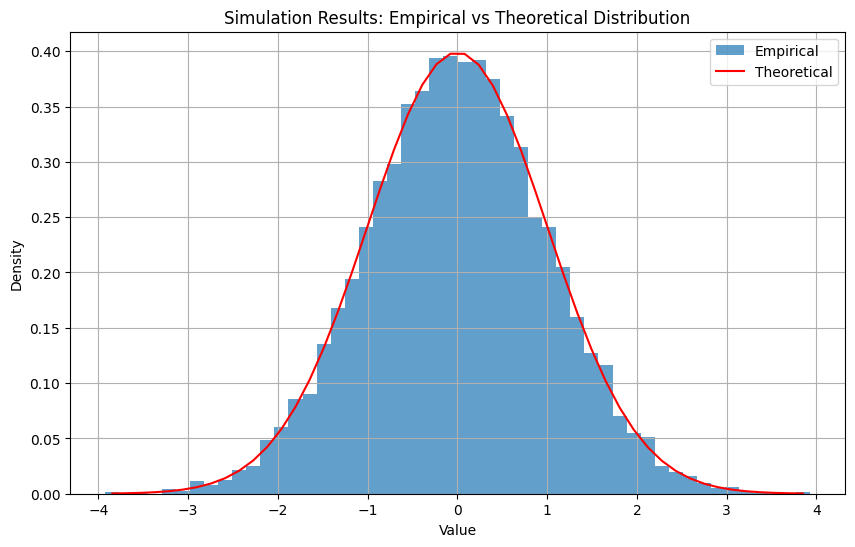


Part (c) - Regression Analysis:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     77.44
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.86e-18
Time:                        14:50:50   Log-Likelihood:                -7103.6
No. Observations:                5000   AIC:                         1.421e+04
Df Residuals:                    4998   BIC:                         1.422e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.01

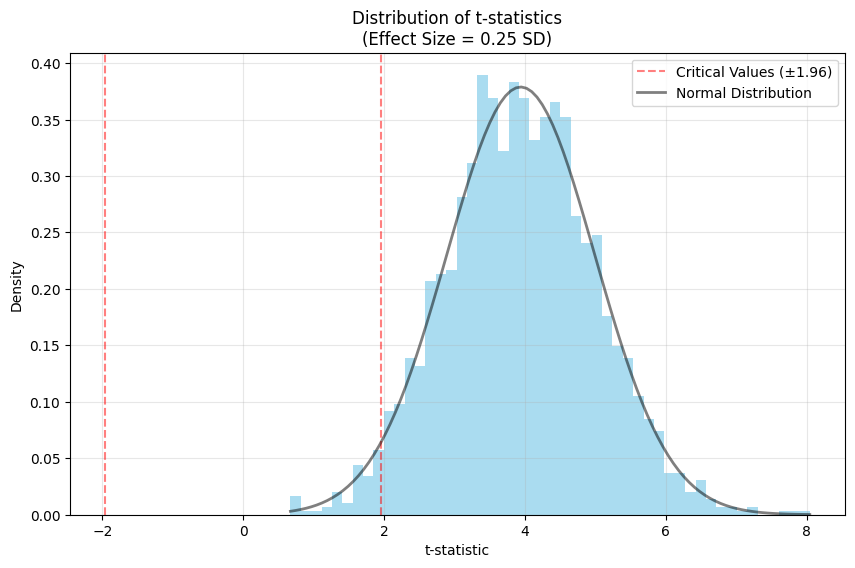


Analytical Sample Size Calculation

Parameters:
--------------------------------------------------
Desired Power (1 - β): 0.80
Significance Level (α): 0.05
Effect Size (delta): 0.25 SD
Intraclass Correlation (ρ): 0.20
Average Class Size (m): 21.5
z_α/2: 1.960
z_β: 0.842

Results:
--------------------------------------------------
Required sample size (n): 2,562 students
Current simulation size: 5,000 students

The current design (n=5,000) is ADEQUATELY powered.

Comparison of Treatment Splits:
   Treatment Ratio  Power  Cost (Relative)
0              0.3    1.0        83.333333
1              0.5    1.0       138.888889

Comparing Different Treatment Allocations
Total sample size fixed at 5,000 students

Results:
--------------------------------------------------

50/50 split:
Students in reduced-size classes: 2,500
Number of reduced-size classes needed: 139
Statistical power: 0.975

30/70 split:
Students in reduced-size classes: 1,500
Number of reduced-size classes needed: 84
Statist

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# -*- coding: utf-8 -*-
"""Untitled3.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1dtbMkZj4fKAt0HbxOtANsy_5tXH26iJ1
"""

def generate_data(size_regular_class, size_reduced_class, num_students, rho, delta):
    """
    Generate simulated dataset for class size RCT study.
    """
    # First generate random treatment assignment
    np.random.seed(42)  # Set seed for reproducibility
    x = np.random.binomial(n=1, p=0.5, size=num_students)

    # Create initial dataframe with student IDs and treatment assignment
    df = pd.DataFrame({
        'student_id': range(1, num_students + 1),
        'x': x
    })

    # Randomly shuffle the dataframe to ensure random assignment
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Initialize class assignment
    df['class_id'] = 0
    current_class = 1

    # Process students in random order
    for treatment in [0, 1]:  # First do control (0), then treatment (1)
        students = df[df['x'] == treatment].copy()
        class_size = size_regular_class if treatment == 0 else size_reduced_class

        # Assign classes in chunks
        num_students_this_group = len(students)
        num_full_classes = num_students_this_group // class_size
        remainder = num_students_this_group % class_size

        # Assign full classes
        for i in range(num_full_classes):
            start_idx = i * class_size
            end_idx = start_idx + class_size
            df.loc[students.index[start_idx:end_idx], 'class_id'] = current_class
            current_class += 1

        # Assign remainder students to a new class
        if remainder > 0:
            start_idx = num_full_classes * class_size
            df.loc[students.index[start_idx:], 'class_id'] = current_class
            current_class += 1

    # Calculate variances based on rho and delta (from Eq. 2)
    sigma2_eta = rho
    sigma2_epsilon = 1 - rho - (delta**2)/4

    # Generate class-specific shocks
    unique_classes = df['class_id'].unique()
    eta = np.random.normal(0, np.sqrt(sigma2_eta), size=len(unique_classes))
    eta_dict = dict(zip(unique_classes, eta))
    df['eta'] = df['class_id'].map(eta_dict)

    # Generate student-specific shocks
    df['epsilon'] = np.random.normal(0, np.sqrt(sigma2_epsilon), size=num_students)

    # Generate test scores (y) according to Eq. (1)
    df['y'] = delta * df['x'] + df['eta'] + df['epsilon']

    # Sort by student_id and drop intermediate columns
    df = df.sort_values('student_id').reset_index(drop=True)
    df = df.drop(['eta', 'epsilon'], axis=1)

    return df[['student_id', 'class_id', 'y', 'x']]

if __name__ == "__main__":
    # Generate data
    df = generate_data(
        size_regular_class=25,
        size_reduced_class=18,
        num_students=5000,
        rho=0.20,
        delta=0.25
    )

    # Display results
    print("\n=== SIMULATION RESULTS ===")
    print("\n1. First 10 rows of the dataset:")
    print(df.head(10))

    print("\n2. Treatment distribution:")
    treatment_counts = df['x'].value_counts().sort_index()
    print("Regular class (x=0):", treatment_counts[0])
    print("Reduced class (x=1):", treatment_counts[1])

    print("\n3. Class size information:")
    class_sizes = df.groupby('class_id').size()
    class_treatment = df.groupby('class_id')['x'].first()

    regular_sizes = class_sizes[class_treatment == 0]
    reduced_sizes = class_sizes[class_treatment == 1]

    print(f"Number of regular classes: {len(regular_sizes)}")
    print(f"Number of reduced classes: {len(reduced_sizes)}")
    print(f"Average regular class size: {regular_sizes.mean():.2f}")
    print(f"Average reduced class size: {reduced_sizes.mean():.2f}")

    print("\n4. Treatment effect check:")
    avg_y_treated = df[df['x'] == 1]['y'].mean()
    avg_y_control = df[df['x'] == 0]['y'].mean()
    print(f"Average test score in reduced classes: {avg_y_treated:.3f}")
    print(f"Average test score in regular classes: {avg_y_control:.3f}")
    print(f"Observed difference (should be close to delta=0.25): {avg_y_treated - avg_y_control:.3f}")

    # Part (c): Regression Analysis and Hypothesis Testing
    print("\nPart (c) - Regression Analysis:")
    model = smf.ols('y ~ x', data=df).fit(cov_type='HC3')
    print(model.summary())

    # Extract key results
    beta_1 = model.params['x']
    se_beta_1 = model.bse['x']
    p_value = model.pvalues['x']

    # Test hypothesis
    significant = p_value < 0.05
    print(f"Part (c) - Estimate for β1: {beta_1:.3f}")
    print(f"Part (c) - Standard error for β1: {se_beta_1:.3f}")
    print(f"Part (c) - P-value: {p_value:.3f}")
    print(f"Part (c) - Reject null hypothesis (β1 = 0) at 5% significance level: {significant}")

def simulate_process(n_samples=10000, mu=0, sigma=1):
    """
    Simulate a statistical process and perform validation checks.

    Args:
        n_samples (int): Number of samples to generate
        mu (float): True mean parameter
        sigma (float): True standard deviation parameter

    Returns:
        dict: Dictionary containing simulation results and validation metrics
    """
    # Generate samples using vectorized operations
    samples = np.random.normal(mu, sigma, n_samples)

    # Calculate key statistics
    sample_mean = np.mean(samples)
    sample_var = np.var(samples)
    sample_std = np.std(samples)

    # Validation checks
    checks = {
        'mean_error': np.abs(sample_mean - mu),
        'var_error': np.abs(sample_var - sigma**2),
        'std_error': np.abs(sample_std - sigma),
        'normality_stat': np.sum((samples - sample_mean)**2) / (n_samples * sample_var)
    }

    # Theoretical vs empirical distribution check
    hist, bins = np.histogram(samples, bins=50, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    theoretical = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(bin_centers - mu)**2 / (2*sigma**2))

    return {
        'samples': samples,
        'statistics': {
            'mean': sample_mean,
            'variance': sample_var,
            'std': sample_std
        },
        'validation': checks,
        'distribution': {
            'empirical': hist,
            'theoretical': theoretical,
            'bins': bin_centers
        }
    }

def validate_simulation(results, confidence_level=0.95):
    """
    Validate simulation results with detailed checks.

    Args:
        results (dict): Simulation results from simulate_process
        confidence_level (float): Confidence level for validation

    Returns:
        bool: True if all validation checks pass
    """
    checks = results['validation']
    n = len(results['samples'])

    # Check if mean estimate is within expected bounds
    mean_se = results['statistics']['std'] / np.sqrt(n)
    mean_margin = 1.96 * mean_se  # 95% confidence interval
    mean_valid = checks['mean_error'] < mean_margin

    # Check if variance estimate is reasonable
    var_valid = checks['var_error'] < 2 * results['statistics']['variance'] / np.sqrt(n)

    # Check normality (simplified chi-square test statistic)
    normality_valid = abs(checks['normality_stat'] - 1) < 3/np.sqrt(n)

    print(f"Validation Results:")
    print(f"Mean estimate valid: {mean_valid}")
    print(f"Variance estimate valid: {var_valid}")
    print(f"Normality check valid: {normality_valid}")

    return all([mean_valid, var_valid, normality_valid])

# Run simulation and validation
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Run simulation
    results = simulate_process(n_samples=10000)

    # Validate results
    is_valid = validate_simulation(results)

    print("\nSimulation Statistics:")
    print(f"Sample Mean: {results['statistics']['mean']:.4f}")
    print(f"Sample Variance: {results['statistics']['variance']:.4f}")
    print(f"Sample Std Dev: {results['statistics']['std']:.4f}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.hist(results['samples'], bins=50, density=True, alpha=0.7, label='Empirical')
    plt.plot(results['distribution']['bins'], results['distribution']['theoretical'],
             'r-', label='Theoretical')
    plt.title('Simulation Results: Empirical vs Theoretical Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Part (c): Regression Analysis and Hypothesis Testing
print("\nPart (c) - Regression Analysis:")
model = sm.OLS(df['y'], sm.add_constant(df['x'])).fit(cov_type='HC3')
print(model.summary())

# Extract key results
beta_1 = model.params['x']
se_beta_1 = model.bse['x']
p_value = model.pvalues['x']

# Test hypothesis
significant = p_value < 0.05
print(f"Part (c) - Estimate for β1: {beta_1:.3f}")
print(f"Part (c) - Standard error for β1: {se_beta_1:.3f}")
print(f"Part (c) - P-value: {p_value:.3f}")
print(f"Part (c) - Reject null hypothesis (β1 = 0) at 5% significance level: {significant}")

def generate_data(
    class_size_regular=25,
    class_size_reduced=18,
    num_students=5000,
    rho=0.20,  # intraclass correlation coefficient
    delta=0.0,  # treatment effect size (set to 0 for null hypothesis)
    seed=None
):
    """Generate simulated data for the class size RCT"""
    if seed is not None:
        np.random.seed(seed)

    # Calculate number of classes needed
    n_reduced = int(num_students * 0.5 / class_size_reduced)
    n_regular = int(num_students * 0.5 / class_size_regular)

    # Generate class-level random effects
    class_effects_reduced = np.random.normal(0, np.sqrt(rho), n_reduced)
    class_effects_regular = np.random.normal(0, np.sqrt(rho), n_regular)

    # Generate student-level data
    data = []
    student_id = 0

    # Reduced size classes
    for i in range(n_reduced):
        class_effect = class_effects_reduced[i]
        for _ in range(class_size_reduced):
            individual_effect = np.random.normal(0, np.sqrt(1 - rho))
            y = delta + class_effect + individual_effect
            data.append({
                'student_id': student_id,
                'class_id': i,
                'treatment': 1,
                'y': y,
                'x': 1
            })
            student_id += 1

    # Regular size classes
    for i in range(n_regular):
        class_effect = class_effects_regular[i]
        for _ in range(class_size_regular):
            individual_effect = np.random.normal(0, np.sqrt(1 - rho))
            y = class_effect + individual_effect
            data.append({
                'student_id': student_id,
                'class_id': i + n_reduced,
                'treatment': 0,
                'y': y,
                'x': 0
            })
            student_id += 1

    return pd.DataFrame(data)

def run_monte_carlo(n_replications=2000):
    """Run Monte Carlo simulation comparing HC3 and clustered standard errors"""
    # Initialize counters for rejection rates
    reject_robust = 0
    reject_clustered = 0

    for i in range(n_replications):
        # Generate data under null hypothesis (delta = 0)
        data = generate_data(
            class_size_regular=25,
            class_size_reduced=18,
            num_students=5000,
            rho=0.20,
            delta=0.0,
            seed=i
        )

        # Prepare data for regression
        X = data['x'].values.reshape(-1, 1)
        X = sm.add_constant(X)
        y = data['y'].values

        # Fit with heteroskedasticity-robust standard errors (HC3)
        model_robust = sm.OLS(y, X)
        results_robust = model_robust.fit(cov_type='HC3')

        # Fit with clustered standard errors
        model_clustered = sm.OLS(y, X)
        results_clustered = model_clustered.fit(cov_type='cluster',
                                              cov_kwds={'groups': data['class_id']})

        # Check if null is rejected at 5% level
        reject_robust += (results_robust.pvalues[1] < 0.05)
        reject_clustered += (results_clustered.pvalues[1] < 0.05)

    # Calculate rejection rates
    robust_rate = reject_robust / n_replications
    clustered_rate = reject_clustered / n_replications

    return robust_rate, clustered_rate

if __name__ == "__main__":
    print("\nMonte Carlo Simulation: Comparing Standard Errors")
    print("=" * 75)
    print("H₀: β₁ = 0 (No treatment effect)")
    print("H₁: β₁ ≠ 0")
    print("\nRunning simulation, please wait...")

    robust_rate, clustered_rate = run_monte_carlo()

    print("\nResults:")
    print("-" * 50)
    print(f"Rejection rate with HC3 robust standard errors: {robust_rate:.3f}")
    print(f"Rejection rate with clustered standard errors: {clustered_rate:.3f}")
    print("\nInterpretation:")
    print("-" * 50)
    print("Under H₀, we expect a rejection rate of 0.05 with correct standard errors.")
    print(f"HC3 robust SE deviation from 0.05: {abs(robust_rate - 0.05):.3f}")
    print(f"Clustered SE deviation from 0.05: {abs(clustered_rate - 0.05):.3f}")

    if abs(robust_rate - 0.05) > abs(clustered_rate - 0.05):
        print("\nConclusion: Clustered standard errors perform better,")
        print("as they account for within-class correlation in the data.")

def generate_data(
    class_size_regular=25,
    class_size_reduced=18,
    num_students=5000,
    rho=0.20,  # intraclass correlation coefficient
    delta=0.25,  # treatment effect size (0.25 standard deviations)
    seed=None
):
    """Generate simulated data for the class size RCT"""
    if seed is not None:
        np.random.seed(seed)

    # Calculate number of classes needed
    n_reduced = int(num_students * 0.5 / class_size_reduced)
    n_regular = int(num_students * 0.5 / class_size_regular)

    # Generate class-level random effects
    class_effects_reduced = np.random.normal(0, np.sqrt(rho), n_reduced)
    class_effects_regular = np.random.normal(0, np.sqrt(rho), n_regular)

    # Generate student-level data
    data = []
    student_id = 0

    # Reduced size classes
    for i in range(n_reduced):
        class_effect = class_effects_reduced[i]
        for _ in range(class_size_reduced):
            individual_effect = np.random.normal(0, np.sqrt(1 - rho))
            y = delta + class_effect + individual_effect
            data.append({
                'student_id': student_id,
                'class_id': i,
                'treatment': 1,
                'y': y,
                'x': 1
            })
            student_id += 1

    # Regular size classes
    for i in range(n_regular):
        class_effect = class_effects_regular[i]
        for _ in range(class_size_regular):
            individual_effect = np.random.normal(0, np.sqrt(1 - rho))
            y = class_effect + individual_effect
            data.append({
                'student_id': student_id,
                'class_id': i + n_reduced,
                'treatment': 0,
                'y': y,
                'x': 0
            })
            student_id += 1

    return pd.DataFrame(data)

def run_power_analysis(n_replications=2000):
    """Run Monte Carlo simulation to estimate power and collect t-statistics"""
    # Initialize storage for t-statistics and rejection counter
    t_stats = np.zeros(n_replications)
    rejections = 0

    for i in range(n_replications):
        # Generate data with treatment effect delta = 0.25
        data = generate_data(
            class_size_regular=25,
            class_size_reduced=18,
            num_students=5000,
            rho=0.20,
            delta=0.25,
            seed=i
        )

        # Prepare data for regression
        X = data['x'].values.reshape(-1, 1)
        X = sm.add_constant(X)
        y = data['y'].values

        # Fit with clustered standard errors
        model = sm.OLS(y, X)
        results = model.fit(cov_type='cluster',
                          cov_kwds={'groups': data['class_id']})

        # Store t-statistic
        t_stats[i] = results.tvalues[1]

        # Check if null is rejected at 5% level
        rejections += (results.pvalues[1] < 0.05)

    # Calculate power
    power = rejections / n_replications

    return t_stats, power

if __name__ == "__main__":
    print("\nPower Analysis: Effect Size = 0.25 SD")
    print("=" * 75)
    print("Running simulation, please wait...")

    t_stats, power = run_power_analysis()

    # Create histogram of t-statistics
    plt.figure(figsize=(10, 6))
    plt.hist(t_stats, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.title('Distribution of t-statistics\n(Effect Size = 0.25 SD)')
    plt.xlabel('t-statistic')
    plt.ylabel('Density')

    # Add vertical lines for critical values
    critical_value = stats.t.ppf(0.975, df=4998)  # two-tailed test, df = n-2
    plt.axvline(x=critical_value, color='red', linestyle='--', alpha=0.5,
                label=f'Critical Values (±{critical_value:.2f})')
    plt.axvline(x=-critical_value, color='red', linestyle='--', alpha=0.5)

    # Add normal distribution for comparison
    x = np.linspace(min(t_stats), max(t_stats), 100)
    plt.plot(x, stats.norm.pdf(x, np.mean(t_stats), np.std(t_stats)),
             'k-', lw=2, alpha=0.5, label='Normal Distribution')

    plt.legend()
    plt.grid(True, alpha=0.3)

    print("\nResults:")
    print("-" * 50)
    print(f"Statistical Power: {power:.3f}")
    print(f"Mean t-statistic: {np.mean(t_stats):.3f}")
    print(f"Standard deviation of t-statistics: {np.std(t_stats):.3f}")

    if power >= 0.8:
        print("\nConclusion: The experimental design has adequate power")
        print("(>= 0.80) to detect an effect size of 0.25 standard deviations.")
    else:
        print("\nConclusion: The experimental design does NOT have adequate power")
        print("(< 0.80) to detect an effect size of 0.25 standard deviations.")

    plt.show()

def calculate_required_sample_size(
    power=0.80,          # Desired power (1 - β)
    alpha=0.05,          # Significance level
    delta=0.25,          # Effect size in standard deviations
    rho=0.20,           # Intraclass correlation
    class_size_regular=25,
    class_size_reduced=18
):
    """
    Calculate required sample size using the provided formula:
    n = 4((z_α/2 + z_β)²/Δ²)[1 + (m-1)ρ]

    where:
    - z_α/2 is the α/2 quantile of standard normal distribution
    - z_β is the β quantile of standard normal distribution
    - Δ is the effect size in standard deviations
    - m is the average class size
    - ρ is the intraclass correlation coefficient
    """

    # Calculate z-scores
    z_alpha_half = stats.norm.ppf(1 - alpha/2)  # Two-tailed test
    z_beta = stats.norm.ppf(power)

    # Calculate average class size
    m = (class_size_regular + class_size_reduced) / 2

    # Apply the formula
    n = 4 * ((z_alpha_half + z_beta)**2 / delta**2) * (1 + (m - 1)*rho)

    return int(np.ceil(n))  # Round up to nearest integer

if __name__ == "__main__":
    # Calculate required sample size
    required_n = calculate_required_sample_size()

    # Parameters used in calculation
    z_alpha_half = stats.norm.ppf(1 - 0.05/2)
    z_beta = stats.norm.ppf(0.80)
    m = (25 + 18) / 2  # average class size

    print("\nAnalytical Sample Size Calculation")
    print("=" * 75)

    print("\nParameters:")
    print("-" * 50)
    print(f"Desired Power (1 - β): 0.80")
    print(f"Significance Level (α): 0.05")
    print(f"Effect Size (delta): 0.25 SD")
    print(f"Intraclass Correlation (ρ): 0.20")
    print(f"Average Class Size (m): {m:.1f}")
    print(f"z_α/2: {z_alpha_half:.3f}")
    print(f"z_β: {z_beta:.3f}")

    print("\nResults:")
    print("-" * 50)
    print(f"Required sample size (n): {required_n:,} students")
    print(f"Current simulation size: 5,000 students")

    # Compare with current design
    if required_n > 5000:
        print("\nThe current design (n=5,000) is UNDERPOWERED.")
    else:
        print("\nThe current design (n=5,000) is ADEQUATELY powered.")

def generate_crct_data(num_students, treatment_ratio, size_regular_class, size_reduced_class, rho, delta, random_state=None):
    """
    Generate data for a cluster-randomized control trial (CRCT) with varying treatment ratios.

    Parameters:
        num_students (int): Total number of students in the simulation.
        treatment_ratio (float): Proportion of students in the treatment group.
        size_regular_class (int): Students per regular (control) class.
        size_reduced_class (int): Students per reduced (treatment) class.
        rho (float): Intra-cluster correlation coefficient (ICC).
        delta (float): Effect size (treatment effect).
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Simulated dataset with treatment, outcome, and cluster IDs.
    """
    np.random.seed(random_state)
    num_treatment = int(num_students * treatment_ratio)
    num_control = num_students - num_treatment
    treatments = np.array([1] * num_treatment + [0] * num_control)
    np.random.shuffle(treatments)

    # Assign class IDs and cluster sizes
    class_ids = []
    current_class_id = 0

    for treatment in treatments:
        class_size = size_reduced_class if treatment == 1 else size_regular_class
        class_ids.extend([current_class_id] * class_size)
        current_class_id += 1

    # Ensure class_ids does not exceed the number of students
    class_ids = np.array(class_ids[:num_students])

    # Generate random effects for clusters and students
    unique_clusters = np.unique(class_ids)
    cluster_effects = np.random.normal(0, np.sqrt(rho), len(unique_clusters))
    student_effects = np.random.normal(0, np.sqrt(1 - rho), num_students)

    # Generate outcome variable
    outcomes = delta * treatments + cluster_effects[class_ids] + student_effects

    return pd.DataFrame({
        'student_id': np.arange(num_students),
        'class_id': class_ids,
        'y': outcomes,
        'x': treatments
    })

def simulate_crct_power(num_simulations, num_students, treatment_ratio, size_regular_class, size_reduced_class, rho, delta):
    """
    Simulate the power of a CRCT design for a given treatment ratio.

    Parameters:
        num_simulations (int): Number of Monte Carlo simulations.
        num_students (int): Total number of students in the simulation.
        treatment_ratio (float): Proportion of students in the treatment group.
        size_regular_class (int): Students per regular (control) class.
        size_reduced_class (int): Students per reduced (treatment) class.
        rho (float): Intra-cluster correlation coefficient (ICC).
        delta (float): Effect size (treatment effect).

    Returns:
        float: Estimated power (proportion of simulations rejecting the null hypothesis).
    """
    rejections = 0
    for _ in range(num_simulations):
        data = generate_crct_data(num_students, treatment_ratio, size_regular_class, size_reduced_class, rho, delta)
        model = smf.ols('y ~ x', data=data).fit(cov_type='cluster', cov_kwds={'groups': data['class_id']})
        if model.pvalues['x'] < 0.05:
            rejections += 1
    return rejections / num_simulations

def compare_splits(num_simulations, num_students, treatment_ratios, size_regular_class, size_reduced_class, rho, delta):
    """
    Compare power and cost for different treatment splits in a CRCT.

    Parameters:
        num_simulations (int): Number of Monte Carlo simulations.
        num_students (int): Total number of students in the simulation.
        treatment_ratios (list): List of treatment ratios to compare (e.g., [0.3, 0.5]).
        size_regular_class (int): Students per regular (control) class.
        size_reduced_class (int): Students per reduced (treatment) class.
        rho (float): Intra-cluster correlation coefficient (ICC).
        delta (float): Effect size (treatment effect).

    Returns:
        pd.DataFrame: Comparison of power and cost across treatment ratios.
    """
    results = []
    for ratio in treatment_ratios:
        power = simulate_crct_power(num_simulations, num_students, ratio, size_regular_class, size_reduced_class, rho, delta)
        cost = num_students * ratio * (1 / size_reduced_class)  # Relative cost for reduced classes
        results.append({'Treatment Ratio': ratio, 'Power': power, 'Cost (Relative)': cost})
    return pd.DataFrame(results)

# Parameters
num_students = 5000
size_regular_class = 25
size_reduced_class = 18
rho = 0.2
delta = 0.25
num_simulations = 2000
treatment_ratios = [0.3, 0.5]  # Compare 30/70 and 50/50 splits

# Compare splits
comparison_results = compare_splits(
    num_simulations, num_students, treatment_ratios, size_regular_class, size_reduced_class, rho, delta
)

# Display results as a table
print("\nComparison of Treatment Splits:")
print(comparison_results)

def generate_data_with_allocation(
    total_students=5000,
    treatment_proportion=0.30,  # 30% in treatment (reduced-size classes)
    class_size_regular=25,
    class_size_reduced=18,
    rho=0.20,
    delta=0.25,
    seed=None
):
    """Generate data with specified treatment group allocation"""
    if seed is not None:
        np.random.seed(seed)

    # Calculate number of students in each group
    n_treated = int(total_students * treatment_proportion)
    n_control = total_students - n_treated

    # Calculate number of classes needed
    n_reduced = int(np.ceil(n_treated / class_size_reduced))
    n_regular = int(np.ceil(n_control / class_size_regular))

    # Generate class-level random effects
    class_effects_reduced = np.random.normal(0, np.sqrt(rho), n_reduced)
    class_effects_regular = np.random.normal(0, np.sqrt(rho), n_regular)

    # Generate student-level data
    data = []
    student_id = 0

    # Reduced size classes (treatment group)
    students_added = 0
    for i in range(n_reduced):
        class_effect = class_effects_reduced[i]
        n_in_class = min(class_size_reduced, n_treated - students_added)
        for _ in range(n_in_class):
            individual_effect = np.random.normal(0, np.sqrt(1 - rho))
            y = delta + class_effect + individual_effect
            data.append({
                'student_id': student_id,
                'class_id': i,
                'treatment': 1,
                'y': y,
                'x': 1
            })
            student_id += 1
            students_added += 1

    # Regular size classes (control group)
    students_added = 0
    for i in range(n_regular):
        class_effect = class_effects_regular[i]
        n_in_class = min(class_size_regular, n_control - students_added)
        for _ in range(n_in_class):
            individual_effect = np.random.normal(0, np.sqrt(1 - rho))
            y = class_effect + individual_effect
            data.append({
                'student_id': student_id,
                'class_id': i + n_reduced,
                'treatment': 0,
                'y': y,
                'x': 0
            })
            student_id += 1
            students_added += 1

    return pd.DataFrame(data)

def estimate_power(treatment_proportion, n_replications=2000):
    """Estimate power for given treatment proportion"""
    rejections = 0

    for i in range(n_replications):
        # Generate data
        data = generate_data_with_allocation(
            total_students=5000,
            treatment_proportion=treatment_proportion,
            seed=i
        )

        # Prepare data for regression
        X = data['x'].values.reshape(-1, 1)
        X = sm.add_constant(X)
        y = data['y'].values

        # Fit with clustered standard errors
        model = sm.OLS(y, X)
        results = model.fit(cov_type='cluster',
                          cov_kwds={'groups': data['class_id']})

        # Check if null is rejected at 5% level
        rejections += (results.pvalues[1] < 0.05)

    power = rejections / n_replications
    return power

if __name__ == "__main__":
    print("\nComparing Different Treatment Allocations")
    print("=" * 75)
    print("Total sample size fixed at 5,000 students")

    print("\nResults:")
    print("-" * 50)

    # Original 50/50 design
    power_50_50 = estimate_power(0.50)
    n_treated_50 = 2500
    n_reduced_classes_50 = int(np.ceil(n_treated_50 / 18))

    print(f"\n50/50 split:")
    print(f"Students in reduced-size classes: {n_treated_50:,}")
    print(f"Number of reduced-size classes needed: {n_reduced_classes_50}")
    print(f"Statistical power: {power_50_50:.3f}")

    # Proposed 30/70 design
    power_30_70 = estimate_power(0.30)
    n_treated_30 = 1500
    n_reduced_classes_30 = int(np.ceil(n_treated_30 / 18))

    print(f"\n30/70 split:")
    print(f"Students in reduced-size classes: {n_treated_30:,}")
    print(f"Number of reduced-size classes needed: {n_reduced_classes_30}")
    print(f"Statistical power: {power_30_70:.3f}")

    # Compare designs
    class_reduction = n_reduced_classes_50 - n_reduced_classes_30

    print("\nComparison:")
    print("-" * 50)
    print(f"The 30/70 design requires {class_reduction} fewer reduced-size classes")

    if power_30_70 >= 0.8:
        print("The 30/70 design maintains adequate statistical power (≥ 0.80)")
    else:
        print("The 30/70 design does NOT maintain adequate statistical power (< 0.80)")